# HPCSeries + Kaggle: Store Sales Forecasting

**Competition:** [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

This notebook demonstrates:
- **HPCSeries-powered feature engineering** (3-10x faster rolling statistics)
- **XGBoost model** optimized for your CPU
- **Store Sales prediction** with validation metrics

---

## 1. Setup & Imports

Load required libraries and check HPCSeries availability.

In [1]:
# ============================================================
# Cell 1: Environment & Library Setup
# ============================================================
import os
import sys
import gc
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 1. Paths / imports
# ------------------------------------------------------------

# Add parent directory to path for local hpcs import
sys.path.insert(0, os.path.abspath(".."))

# HPCSeries import
HPCS_AVAILABLE = False
try:
    import hpcs

    print(f"✓ HPCSeries loaded successfully (v{hpcs.__version__})")
    try:
        simd = hpcs.simd_info()
        print(f"  SIMD ISA:    {simd.get('isa', 'unknown')}")
        print(f"  SIMD width:  {simd.get('width_doubles', '??')} doubles")
    except Exception:
        print("  (SIMD info not available)")
    HPCS_AVAILABLE = True
except ImportError as e:
    print(f"❌ HPCSeries not found: {e}")
    print("   Will use NumPy/pandas fallback (slower)")
    HPCS_AVAILABLE = False

# XGBoost import
XGB_AVAILABLE = False
try:
    import xgboost as xgb

    print(f"\n✓ XGBoost loaded (v{xgb.__version__})")
    XGB_AVAILABLE = True
except ImportError:
    print("\n❌ XGBoost not installed. Install with: pip install xgboost")
    XGB_AVAILABLE = False

# scikit-learn for metrics
try:
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    print("✓ scikit-learn loaded")
except ImportError:
    print("❌ scikit-learn not found. Install with: pip install scikit-learn")

# ------------------------------------------------------------
# 2. Global options (plots / pandas / randomness)
# ------------------------------------------------------------

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if XGB_AVAILABLE:
    # XGBoost will also use this seed in params later
    pass

# ------------------------------------------------------------
# 3. Small helper utilities
# ------------------------------------------------------------

def df_mem_gb(df: pd.DataFrame, name: str = "DataFrame") -> float:
    """
    Print and return memory usage of a DataFrame in GB.
    """
    mem_gb = df.memory_usage(deep=True).sum() / 1024**3
    print(f"📦 {name} memory usage: {mem_gb:.3f} GB (shape={df.shape})")
    return mem_gb


def gc_collect(tag: str = ""):
    """
    Run garbage collection and optionally log a tag.
    """
    freed = gc.collect()
    if tag:
        print(f"🧹 GC collected {freed} objects after {tag}")
    return freed


print("\n" + "=" * 60)
print("Setup complete!")
print("=" * 60)
print(f"HPCS_AVAILABLE = {HPCS_AVAILABLE}")
print(f"XGB_AVAILABLE  = {XGB_AVAILABLE}")
print(f"RANDOM_SEED    = {RANDOM_SEED}")
print("=" * 60)


[SIMD] Registered OpenMP SIMD reduction kernels
[SIMD] Registered OpenMP SIMD rolling operations
[SIMD] Z-score kernels initialized
[SIMD Debug] AVX-512=0, AVX2=1, AVX=1, SSE2=1
[SIMD] Detected ISA: AVX2 (256-bit)


✓ HPCSeries loaded successfully (v0.7.0)
  SIMD ISA:    AVX2
  SIMD width:  4 doubles
=== HPCS CPU Detection v0.5 ===
Logical cores:   8
Physical cores:  4
Optimal threads: 4

L1 cache (KB):   32
L2 cache (KB):   512
L3 cache (KB):   4096

NUMA nodes:      1
Cores per node:  4

CPU vendor:      AuthenticAMD
SIMD width:      256 bits
Has SSE2:        T
Has AVX:         T
Has AVX2:        T
Has AVX-512:     F
Has NEON:        F
Has FMA3:        T

✓ XGBoost loaded (v3.1.2)
✓ scikit-learn loaded

Setup complete!
HPCS_AVAILABLE = True
XGB_AVAILABLE  = True
RANDOM_SEED    = 42




## 2. Load Kaggle Data

Load the Store Sales competition datasets from local storage.

In [2]:
# ============================================================
# Cell 2: Load core Kaggle Store Sales datasets (memory-optimized)
# ============================================================
import os
import gc

# Adjust this to your actual location
DATA_DIR = "data/kaggle" 

print("=" * 60)
print("Loading core datasets with optimized dtypes...")
print("=" * 60)

# ------------------------------------------------------------
# 1) Core train
# ------------------------------------------------------------
train_dtypes = {
    "id": "int32",
    "store_nbr": "int16",
    "family": "category",
    "onpromotion": "int16",   # can go to int8 later if you want
}

train = pd.read_csv(
    os.path.join(DATA_DIR, "train.csv"),
    usecols=["date", "store_nbr", "family", "sales", "onpromotion"],
    dtype=train_dtypes,
    parse_dates=["date"],
)

# sales as float32 to reduce size
train["sales"] = train["sales"].astype("float32")

print("✓ Train loaded:", train.shape)
df_mem_gb(train, "train (raw)")

# ------------------------------------------------------------
# 2) Stores
# ------------------------------------------------------------
stores = pd.read_csv(
    os.path.join(DATA_DIR, "stores.csv"),
    dtype={
        "store_nbr": "int16",
        "city": "category",
        "state": "category",
        "type": "category",
        "cluster": "int8",
    },
)
print("✓ Stores loaded:", stores.shape)

# ------------------------------------------------------------
# 3) Oil
# ------------------------------------------------------------
oil = pd.read_csv(
    os.path.join(DATA_DIR, "oil.csv"),
    dtype={"dcoilwtico": "float32"},
    parse_dates=["date"],
)
print("✓ Oil loaded:", oil.shape)

# ------------------------------------------------------------
# 4) Holidays
# ------------------------------------------------------------
holidays = pd.read_csv(
    os.path.join(DATA_DIR, "holidays_events.csv"),
    parse_dates=["date"],
)

for col in ["type", "locale", "locale_name", "description"]:
    if col in holidays.columns:
        holidays[col] = holidays[col].astype("category")

print("✓ Holidays loaded:", holidays.shape)

# ------------------------------------------------------------
# 5) Transactions
# ------------------------------------------------------------
transactions = pd.read_csv(
    os.path.join(DATA_DIR, "transactions.csv"),
    dtype={
        "store_nbr": "int16",
        "transactions": "int32",  # can downcast further later if needed
    },
    parse_dates=["date"],
)
print("✓ Transactions loaded:", transactions.shape)

gc_collect("after loading all tables")

print("\nAfter loading all tables:")
df_mem_gb(train, "train (after loading)")


Loading core datasets with optimized dtypes...
✓ Train loaded: (3000888, 5)
📦 train (raw) memory usage: 0.048 GB (shape=(3000888, 5))
✓ Stores loaded: (54, 5)
✓ Oil loaded: (1218, 2)
✓ Holidays loaded: (350, 6)
✓ Transactions loaded: (83488, 3)
🧹 GC collected 0 objects after after loading all tables

After loading all tables:
📦 train (after loading) memory usage: 0.048 GB (shape=(3000888, 5))


np.float64(0.04751371219754219)

---

## 3. Data Preprocessing

Merge datasets and handle missing values.

In [3]:
print("Merging datasets...")
print("="*60)

# ------------------------------------------------------------------
# 1) Merge train/test with stores
# ------------------------------------------------------------------
store_cols = ['store_nbr', 'city', 'state', 'type', 'cluster']
stores_small = stores[store_cols].copy()

train = train.merge(stores_small, on="store_nbr", how="left")
if 'test' in globals():
    test = test.merge(stores_small, on="store_nbr", how="left")
    print("✓ Merged train/test with stores")
else:
    print("✓ Merged train with stores (test not loaded yet)")

del stores_small
del stores
gc.collect()

# ------------------------------------------------------------------
# 2) Fix oil prices (float32, not float64)
# ------------------------------------------------------------------
print("Fixing oil prices...")

oil['dcoilwtico'] = (
    oil['dcoilwtico']
    .replace('', np.nan)
    .astype('float32')
    .ffill()
    .bfill()
)
print("✓ Fixed oil prices")

# ------------------------------------------------------------------
# 3) Merge oil into train/test
# ------------------------------------------------------------------
train = train.merge(oil[['date', 'dcoilwtico']], on="date", how="left")
if 'test' in globals():
    test = test.merge(oil[['date', 'dcoilwtico']], on="date", how="left")
    print("✓ Merged train/test with oil")
else:
    print("✓ Merged train with oil")

del oil
gc.collect()

# ------------------------------------------------------------------
# 4) Merge transactions
# ------------------------------------------------------------------
print("Merging transactions into train...")

# Downcast before merging
if transactions['transactions'].dtype == 'int64':
    transactions['transactions'] = transactions['transactions'].astype('int32')

train = train.merge(transactions, on=["date", "store_nbr"], how="left")
print("✓ Merged transactions into train")

# Uncomment if your pipeline actually uses transactions for test.
# if 'test' in globals():
#     test = test.merge(transactions, on=["date", "store_nbr"], how="left")
#     print("✓ Merged transactions into test")

del transactions
gc.collect()

# ------------------------------------------------------------------
# 5) Basic stats
# ------------------------------------------------------------------
print(f"\nTrain shape after merges: {train.shape}")
if 'test' in globals():
    print(f"Test  shape after merges: {test.shape}")

missing_counts = train.isnull().sum()
if missing_counts.sum() > 0:
    print("\nMissing values (train):")
    print(missing_counts[missing_counts > 0])
else:
    print("\n✓ No missing values in train")

df_mem_gb(train, "train (after merges)")
if 'test' in globals():
    print("Approx test  memory (GB):",
          round(test.memory_usage(deep=True).sum() / 1024**3, 3))


Merging datasets...
✓ Merged train with stores (test not loaded yet)
Fixing oil prices...
✓ Fixed oil prices
✓ Merged train with oil
Merging transactions into train...
✓ Merged transactions into train

Train shape after merges: (3000888, 11)

Missing values (train):
dcoilwtico      857142
transactions    245784
dtype: int64
📦 train (after merges) memory usage: 0.092 GB (shape=(3000888, 11))


---

## 4. Time-Based Features

Extract temporal patterns from dates.

In [4]:
print("Creating time features...")
print("="*60)

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add temporal features with compact dtypes."""
    date = df['date']

    # Calendar components
    df['year']        = date.dt.year.astype('int16')    # 2013–2017 fits easily
    df['month']       = date.dt.month.astype('int8')    # 1–12
    df['day']         = date.dt.day.astype('int8')      # 1–31
    df['dayofweek']   = date.dt.dayofweek.astype('int8')  # 0–6
    df['dayofyear']   = date.dt.dayofyear.astype('int16') # 1–366

    # isocalendar().week returns UInt32 in modern pandas; cast down
    df['weekofyear']  = date.dt.isocalendar().week.astype('int16')

    df['quarter']     = date.dt.quarter.astype('int8')

    # Flags – int8 or bool, your choice. I’ll keep int8 to be consistent with others.
    df['is_weekend']       = (df['dayofweek'] >= 5).astype('int8')
    df['is_month_start']   = date.dt.is_month_start.astype('int8')
    df['is_month_end']     = date.dt.is_month_end.astype('int8')
    df['is_quarter_start'] = date.dt.is_quarter_start.astype('int8')
    df['is_quarter_end']   = date.dt.is_quarter_end.astype('int8')

    return df

# Apply to train 
train = add_time_features(train)

# Apply to test only if it's actually loaded
if 'test' in globals():
    test = add_time_features(test)

time_features = [
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter',
    'is_weekend', 'is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end'
]

print(f"✓ Added {len(time_features)} time features")
print(f"  Features: {', '.join(time_features[:5])}...")


Creating time features...
✓ Added 12 time features
  Features: year, month, day, dayofweek, dayofyear...


---

## 5. HPCSeries Rolling Features

Compute rolling statistics using HPCSeries

In [5]:
import time

print("Creating rolling features with HPCSeries...")
print("="*60)

# Ensure deterministic row order and contiguous index for NumPy indexing
train = train.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

start_time = time.time()

windows = [7, 28, 56]

if HPCS_AVAILABLE:
    print("Using HPCSeries (SIMD-accelerated)")
    # You can introspect simd_info() if you like:
    # simd = hpcs.simd_info(); print(simd)

    def add_rolling_features_hpcs(df: pd.DataFrame, windows) -> tuple[pd.DataFrame, list]:
        """
        Add rolling statistics using HPCSeries SIMD operations.

        Strategy:
        - No list(groups): we re-create groupby per window (cheap, avoids big temp list)
        - For each window:
            * Preallocate full-length NumPy arrays (float32) per feature
            * Iterate over groups, compute HPC rolling stats for that group
            * Assign into arrays by integer position (index after reset_index)
        - At the end of each window, attach arrays to df once.
        """
        n = len(df)
        rolling_cols: list[str] = []

        for window in windows:
            print(f"\n  >>> Window {window} days")

            col_mean   = f'sales_roll_mean_{window}'
            col_median = f'sales_roll_median_{window}'
            col_std    = f'sales_roll_std_{window}'
            col_mad    = f'sales_roll_mad_{window}'

            # Preallocate arrays for this window (float32 to save memory)
            arr_mean   = np.full(n, np.nan, dtype=np.float32)
            arr_median = np.full(n, np.nan, dtype=np.float32)
            arr_std    = np.full(n, np.nan, dtype=np.float32)
            arr_mad    = np.full(n, np.nan, dtype=np.float32)

            # Fresh groupby per window – avoids storing all subframes in memory
            gb = df.groupby(['store_nbr', 'family'], sort=False)
            n_groups = gb.ngroups
            print(f"  Processing {n_groups} (store, family) groups")

            for i, (_, group) in enumerate(gb):
                idx = group.index.to_numpy()  # 0..n-1 after reset_index
                sales = group['sales'].to_numpy(dtype=np.float64)

                if len(sales) >= window:
                    try:
                        # HPCSeries rolling operations (float64 in, float64 out)
                        r_mean   = hpcs.rolling_mean(sales, window)
                        r_median = hpcs.rolling_median(sales, window)
                        r_std    = hpcs.rolling_std(sales, window)
                        r_mad    = hpcs.rolling_mad(sales, window)
                    except Exception:
                        # Fallback: pandas rolling for this group only
                        s = group['sales']
                        r_mean   = s.rolling(window, min_periods=1).mean().to_numpy()
                        r_median = s.rolling(window, min_periods=1).median().to_numpy()
                        r_std    = s.rolling(window, min_periods=1).std().to_numpy()
                        # You can choose to skip MAD fallback if not needed:
                        r_mad    = s.rolling(window, min_periods=1).apply(
                            lambda x: np.median(np.abs(x - np.median(x))), raw=False
                        ).to_numpy()

                    # Assign into full-length arrays, cast down to float32
                    arr_mean[idx]   = r_mean.astype(np.float32, copy=False)
                    arr_median[idx] = r_median.astype(np.float32, copy=False)
                    arr_std[idx]    = r_std.astype(np.float32, copy=False)
                    arr_mad[idx]    = r_mad.astype(np.float32, copy=False)

                # Progress logging
                if (i + 1) % 100 == 0 or (i + 1) == n_groups:
                    pct = 100.0 * (i + 1) / n_groups
                    print(f"    Groups processed: {i+1:4d}/{n_groups} ({pct:5.1f}%)", end='\r')

            # Attach arrays as columns once per window
            df[col_mean]   = arr_mean
            df[col_median] = arr_median
            df[col_std]    = arr_std
            df[col_mad]    = arr_mad

            rolling_cols.extend([col_mean, col_median, col_std, col_mad])
            print(f"\n  ✓ Window {window}: features attached")

        return df, rolling_cols

    train, rolling_cols = add_rolling_features_hpcs(train, windows)

else:
    print("Using pandas (slower fallback)")

    rolling_cols = []
    for window in windows:
        col_mean   = f'sales_roll_mean_{window}'
        col_median = f'sales_roll_median_{window}'
        col_std    = f'sales_roll_std_{window}'

        # Pandas groupby/rolling; cast to float32 to save memory
        train[col_mean] = (
            train
            .groupby(['store_nbr', 'family'])['sales']
            .transform(lambda x: x.rolling(window, min_periods=1).mean())
            .astype('float32')
        )
        train[col_median] = (
            train
            .groupby(['store_nbr', 'family'])['sales']
            .transform(lambda x: x.rolling(window, min_periods=1).median())
            .astype('float32')
        )
        train[col_std] = (
            train
            .groupby(['store_nbr', 'family'])['sales']
            .transform(lambda x: x.rolling(window, min_periods=1).std())
            .astype('float32')
        )

        rolling_cols.extend([col_mean, col_median, col_std])
        print(f"  ✓ Window {window}")

elapsed = time.time() - start_time
print(f"\n✓ Created {len(rolling_cols)} rolling features in {elapsed:.1f} seconds")
print(f"  Performance: {train.shape[0] / elapsed:,.0f} rows/sec")


Creating rolling features with HPCSeries...
Using HPCSeries (SIMD-accelerated)

  >>> Window 7 days
  Processing 1782 (store, family) groups
    Groups processed: 1782/1782 (100.0%)
  ✓ Window 7: features attached

  >>> Window 28 days
  Processing 1782 (store, family) groups
    Groups processed: 1782/1782 (100.0%)
  ✓ Window 28: features attached

  >>> Window 56 days
  Processing 1782 (store, family) groups
    Groups processed: 1782/1782 (100.0%)
  ✓ Window 56: features attached

✓ Created 12 rolling features in 21.2 seconds
  Performance: 141,829 rows/sec


---

## 5.2. Derived Ratio Features

Compute relative volatility measures (coefficient of variation, outlier sensitivity).

In [6]:
print("Computing derived ratio features...")
print("="*60)

# These features capture RELATIVE volatility

eps = np.float32(1e-6) 
derived_cols = []

if len(rolling_cols) > 0:
    print("Creating ratio features from rolling statistics...\n")
    
    for window in [7, 28, 56]:
        col_median = f'sales_roll_median_{window}'
        col_mean   = f'sales_roll_mean_{window}'
        col_std    = f'sales_roll_std_{window}'
        col_mad    = f'sales_roll_mad_{window}'
        
        train[col_median] = train[col_median].astype('float32')
        train[col_mean]   = train[col_mean].astype('float32')
        train[col_std]    = train[col_std].astype('float32')
        train[col_mad]    = train[col_mad].astype('float32')

        # 1. MAD / Median - Robust Coefficient of Variation
        col_mad_over_median = f'mad_over_median_{window}'
        train[col_mad_over_median] = (
            train[col_mad].values.astype('float32') /
            (np.abs(train[col_median].values.astype('float32')) + eps)
        ).astype('float32')
        derived_cols.append(col_mad_over_median)
        
        # 2. STD / MAD - Outlier Sensitivity Index
        col_std_over_mad = f'std_over_mad_{window}'
        train[col_std_over_mad] = (
            train[col_std].values.astype('float32') /
            (train[col_mad].values.astype('float32') + eps)
        ).astype('float32')
        derived_cols.append(col_std_over_mad)
        
        # 3. MAD / Mean - Volatility Index (alternative CoV)
        col_volatility_idx = f'volatility_index_{window}'
        train[col_volatility_idx] = (
            train[col_mad].values.astype('float32') /
            (np.abs(train[col_mean].values.astype('float32')) + eps)
        ).astype('float32')
        derived_cols.append(col_volatility_idx)
    
    print(f"✓ Created {len(derived_cols)} derived ratio features")
    print(f"\n Derived Features Summary:")
    print(f"  MAD/Median (robust CoV):     {len([c for c in derived_cols if 'mad_over_median' in c])} features")
    print(f"  STD/MAD (outlier index):     {len([c for c in derived_cols if 'std_over_mad' in c])} features")
    print(f"  MAD/Mean (volatility index): {len([c for c in derived_cols if 'volatility_index' in c])} features")
    
    print(f"\n Why these matter:")
    print(f"  - Scale-invariant: Compare volatility across stores with different sales volumes")
    print(f"  - Outlier-resistant: MAD-based ratios ignore extreme spikes")
    print(f"  - Tree-model friendly: Ratios create clear decision boundaries")
    print(f"  - Information-rich: Capture distribution shape, not just location/scale")
    
else:
    print("Skipping derived features (no rolling features found)")


Computing derived ratio features...
Creating ratio features from rolling statistics...

✓ Created 9 derived ratio features

 Derived Features Summary:
  MAD/Median (robust CoV):     3 features
  STD/MAD (outlier index):     3 features
  MAD/Mean (volatility index): 3 features

 Why these matter:
  - Scale-invariant: Compare volatility across stores with different sales volumes
  - Outlier-resistant: MAD-based ratios ignore extreme spikes
  - Tree-model friendly: Ratios create clear decision boundaries
  - Information-rich: Capture distribution shape, not just location/scale


---

## 5.5. HPCSeries Advanced Features

Add robust statistics and aggregate features using HPCSeries SIMD operations.

In [7]:
print("Creating advanced HPCSeries features...")
print("="*60)

advanced_cols = []
start_adv = time.time()

if HPCS_AVAILABLE:
    print("Using HPCSeries robust statistics and anomaly detection\n")

    # Ensure sorted index is 0..n-1 (we did this in rolling step already,
    # but it's cheap to be defensive)
    train = train.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

    n = len(train)

    # ------------------------------------------------------------
    # Preallocate arrays for all advanced features
    # ------------------------------------------------------------
    rz_global_arr      = np.full(n, np.nan, dtype=np.float32)
    rz_clipped_arr     = np.full(n, np.nan, dtype=np.float32)
    anom_flag_arr      = np.zeros(n, dtype=np.int8)
    anom_count_28_arr  = np.full(n, np.nan, dtype=np.float32)

    group_mean_arr     = np.full(n, np.nan, dtype=np.float32)
    group_std_arr      = np.full(n, np.nan, dtype=np.float32)
    group_median_arr   = np.full(n, np.nan, dtype=np.float32)
    group_mad_arr      = np.full(n, np.nan, dtype=np.float32)
    anom_score_arr     = np.full(n, np.nan, dtype=np.float32)

    # ------------------------------------------------------------
    # 1) GLOBAL robust z-scores (per group)
    # ------------------------------------------------------------
    print("1. Computing GLOBAL robust z-scores (per-group)...")
    print("   (Compares each point to entire group history, not just rolling window)")

    gb = train.groupby(['store_nbr', 'family'], sort=False)
    n_groups = gb.ngroups

    for i, (_, group) in enumerate(gb):
        idx = group.index.to_numpy()  # 0..n-1 after reset_index
        sales = group['sales'].to_numpy(dtype=np.float64)

        if sales.size > 0:
            try:
                # Global robust z-score: (x - median) / (1.4826 * MAD)
                rz_global = hpcs.robust_zscore(sales)  # float64 array

                # Clip and anomaly flags
                rz_clipped = np.clip(rz_global, -10.0, 10.0)
                anom_flags = (np.abs(rz_global) > 3.0).astype(float)

                # Rolling anomaly density in 28-day window
                if sales.size >= 28:
                    anom_count_28 = hpcs.rolling_sum(anom_flags, 28)
                else:
                    # Not enough history: leave as NaN
                    anom_count_28 = np.full_like(anom_flags, np.nan, dtype=np.float64)

                # Store into preallocated arrays (cast down to float32 / int8)
                rz_global_arr[idx]     = rz_global.astype(np.float32, copy=False)
                rz_clipped_arr[idx]    = rz_clipped.astype(np.float32, copy=False)
                anom_flag_arr[idx]     = (np.abs(rz_global) > 3.0).astype(np.int8)
                anom_count_28_arr[idx] = anom_count_28.astype(np.float32, copy=False)

            except Exception:
                # If anything goes wrong for this group, leave NaNs/defaults
                pass

        if (i + 1) % 100 == 0 or (i + 1) == n_groups:
            pct = 100.0 * (i + 1) / n_groups
            print(f"   [groups: {i+1:4d}/{n_groups}] ({pct:5.1f}%)", end='\r')

    # Attach columns once
    train['robust_zscore_global']  = rz_global_arr
    train['robust_zscore_clipped'] = rz_clipped_arr
    train['is_anom_robust_3']      = anom_flag_arr
    train['anom_count_28']         = anom_count_28_arr

    advanced_cols.extend([
        'robust_zscore_global',
        'robust_zscore_clipped',
        'is_anom_robust_3',
        'anom_count_28'
    ])

    print("\n   ✓ Completed global robust z-scores for "
          f"{n_groups} groups" + " " * 20)

    # ------------------------------------------------------------
    # 2) Per-group aggregate statistics
    # ------------------------------------------------------------
    print("\n2. Computing per-group aggregate statistics...")

    gb = train.groupby(['store_nbr', 'family'], sort=False)
    # n_groups is the same, but we can reuse it

    for i, (_, group) in enumerate(gb):
        idx = group.index.to_numpy()
        sales = group['sales'].to_numpy(dtype=np.float64)

        if sales.size > 0:
            try:
                mean_val   = hpcs.mean(sales)
                std_val    = hpcs.std(sales)
                median_val = hpcs.median(sales)
                mad_val    = hpcs.mad(sales)

                # Broadcast group-wide stats to all rows in group
                group_mean_arr[idx]   = np.float32(mean_val)
                group_std_arr[idx]    = np.float32(std_val)
                group_median_arr[idx] = np.float32(median_val)
                group_mad_arr[idx]    = np.float32(mad_val)

                # Standard anomaly score vs mean/std for comparison
                if std_val > 0:
                    scores = np.abs(sales - mean_val) / std_val   # float64 array
                    anom_score_arr[idx] = scores.astype(np.float32, copy=False)
                else:
                    anom_score_arr[idx] = 0.0  # no variation in this group

            except Exception:
                # Leave defaults/NaNs for this group on failure
                pass

        if (i + 1) % 100 == 0 or (i + 1) == n_groups:
            pct = 100.0 * (i + 1) / n_groups
            print(f"   [groups: {i+1:4d}/{n_groups}] ({pct:5.1f}%)", end='\r')

    # Attach columns once
    train['sales_group_mean']     = group_mean_arr
    train['sales_group_std']      = group_std_arr
    train['sales_group_median']   = group_median_arr
    train['sales_group_mad']      = group_mad_arr
    train['sales_anomaly_score']  = anom_score_arr

    advanced_cols.extend([
        'sales_group_mean',
        'sales_group_std',
        'sales_group_median',
        'sales_group_mad',
        'sales_anomaly_score'
    ])

    print("\n   ✓ Completed aggregate statistics for "
          f"{n_groups} groups" + " " * 20)

    # ------------------------------------------------------------
    # Timing + summary
    # ------------------------------------------------------------
    elapsed_adv = time.time() - start_adv
    print(f"\n✓ Created {len(advanced_cols)} advanced features "
          f"in {elapsed_adv:.1f} seconds")
    print(f"  Performance: {train.shape[0] / elapsed_adv:,.0f} rows/sec")

    print(f"\n Advanced Features Summary:")
    print(f"  Global robust z-scores:        4 features "
          f"(global, clipped, binary flag, anomaly density)")
    print(f"  Group aggregates:              5 features "
          f"(mean, std, median, MAD, std z-score)")
    print(f"\n💡 Key insights from the spec:")
    print(f"  - Global vs Rolling: Global compares to entire history, "
          f"rolling to recent window")
    print(f"  - Clipping: Prevents extreme z-scores from dominating "
          f"tree decisions")
    print(f"  - Binary flags: Easier for tree models to split on than "
          f"continuous z-scores")
    print(f"  - Anomaly density: Captures 'volatility clustering' "
          f"(periods of high activity)")
    print(f"  - MAD-based: Robust to outliers (unlike std-based z-scores)")

else:
    print("HPCSeries not available - skipping advanced features")
    print("(These features require robust statistics: MAD, robust_zscore, etc.)")

Creating advanced HPCSeries features...
Using HPCSeries robust statistics and anomaly detection

1. Computing GLOBAL robust z-scores (per-group)...
   (Compares each point to entire group history, not just rolling window)
   [groups: 1782/1782] (100.0%)
   ✓ Completed global robust z-scores for 1782 groups                    

2. Computing per-group aggregate statistics...


[SIMD Debug] AVX-512=0, AVX2=1, AVX=1, SSE2=1
[SIMD] Detected ISA: AVX2 (256-bit)


=== HPCS CPU Detection v0.5 ===
Logical cores:   8
Physical cores:  4
Optimal threads: 4

L1 cache (KB):   32
L2 cache (KB):   512
L3 cache (KB):   4096

NUMA nodes:      1
Cores per node:  4

CPU vendor:      AuthenticAMD
SIMD width:      256 bits
Has SSE2:        T
Has AVX:         T
Has AVX2:        T
Has AVX-512:     F
Has NEON:        F
Has FMA3:        T
   [groups: 1782/1782] (100.0%)
   ✓ Completed aggregate statistics for 1782 groups                    

✓ Created 9 advanced features in 4.6 seconds
  Performance: 652,861 rows/sec

 Advanced Features Summary:
  Global robust z-scores:        4 features (global, clipped, binary flag, anomaly density)
  Group aggregates:              5 features (mean, std, median, MAD, std z-score)

💡 Key insights from the spec:
  - Global vs Rolling: Global compares to entire history, rolling to recent window
  - Clipping: Prevents extreme z-scores from dominating tree decisions
  - Binary flags: Easier for tree models to split on than continuou

---

## 5.6. Structural Features (Seasonality & Scale)

Compute per-store/family structural characteristics that remain constant over time.

In [8]:
print("Computing structural features (seasonality & scale)...")
print("="*60)

structural_cols = []
start_struct = time.time()

if HPCS_AVAILABLE and 'dayofweek' in train.columns:
    print("Analyzing seasonality patterns and scale characteristics...\n")

    # Ensure deterministic, simple index
    train = train.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
    n = len(train)

    # ------------------------------------------------------------
    # 1) Day-of-week seasonality strength (per group, constant)
    # ------------------------------------------------------------
    print("1. Computing day-of-week seasonality strength...")
    print("   (Measures: How much do sales vary by day of week?)")

    # Preallocate array for sf_dow_seasonality_strength
    sf_dow_arr = np.full(n, np.nan, dtype=np.float32)

    gb = train.groupby(['store_nbr', 'family'], sort=False)
    n_groups = gb.ngroups

    for i, (_, group) in enumerate(gb):
        idx = group.index.to_numpy()

        if group.shape[0] > 7:  # Need at least ~one week of data
            try:
                # mean sales per day-of-week within this group
                dow_means = (
                    group.groupby('dayofweek')['sales']
                         .mean()
                         .to_numpy(dtype=np.float64)
                )

                if dow_means.size > 1:
                    # compute std of dow_means using HPCS (or numpy as fallback)
                    seasonality_strength = hpcs.std(dow_means)
                    sf_dow_arr[idx] = np.float32(seasonality_strength)

            except Exception:
                # leave NaNs for this group
                pass

        if (i + 1) % 100 == 0 or (i + 1) == n_groups:
            pct = 100.0 * (i + 1) / n_groups
            print(f"   [groups: {i+1:4d}/{n_groups}] ({pct:5.1f}%)", end='\r')

    train['sf_dow_seasonality_strength'] = sf_dow_arr
    structural_cols.append('sf_dow_seasonality_strength')
    print("\n   ✓ Completed seasonality analysis for "
          f"{n_groups} groups" + " " * 20)

    # ------------------------------------------------------------
    # 2) Coefficient of Variation (scale-normalized volatility)
    # ------------------------------------------------------------
    print("\n2. Computing Coefficient of Variation (scale-normalized volatility)...")
    print("   (Formula: CoV = std / |mean| - compares volatility across different scales)")

    eps = np.float32(1e-6)

    if 'sales_group_std' in train.columns and 'sales_group_mean' in train.columns:
        # Ensure base stats are float32
        std_vals  = train['sales_group_std'].astype('float32').to_numpy()
        mean_vals = train['sales_group_mean'].astype('float32').to_numpy()

        cov_vals = std_vals / (np.abs(mean_vals) + eps)
        train['sf_cov_sales'] = cov_vals.astype('float32')

        structural_cols.append('sf_cov_sales')
        print("   ✓ Computed CoV from existing group statistics")
    else:
        print("   ⚠️ sales_group_mean/std not found, skipping CoV feature")

    elapsed_struct = time.time() - start_struct
    print(f"\n✓ Created {len(structural_cols)} structural features in "
          f"{elapsed_struct:.1f} seconds")

    # Summary
    print(f"\n Structural Features Summary:")
    print(f"  Seasonality strength:    {len([c for c in structural_cols if 'seasonality' in c])} feature(s)")
    print(f"  Scale measures (CoV):    {len([c for c in structural_cols if 'cov' in c])} feature(s)")

    print(f"\n💡 Why seasonality strength matters:")
    print(f"  - Retail data has strong day-of-week patterns (weekends, paydays, etc.)")
    print(f"  - Some stores/products have strong patterns, others don't")
    print(f"  - Helps model learn: 'Is today's sales unusual for THIS day of week?'")
    print(f"  - Example: Weekend surge for entertainment products, weekday for office supplies")

    print(f"\n💡 Why CoV matters:")
    print(f"  - Compares volatility across different sales volumes")
    print(f"  - High CoV = unstable/unpredictable sales")
    print(f"  - Low CoV = stable/predictable sales")
    print(f"  - Scale-invariant: 100±50 vs 1000±500 both have CoV=0.5")

else:
    print("Skipping structural features (HPCSeries not available or missing dayofweek)")


Computing structural features (seasonality & scale)...
Analyzing seasonality patterns and scale characteristics...

1. Computing day-of-week seasonality strength...
   (Measures: How much do sales vary by day of week?)
   [groups: 1782/1782] (100.0%)
   ✓ Completed seasonality analysis for 1782 groups                    

2. Computing Coefficient of Variation (scale-normalized volatility)...
   (Formula: CoV = std / |mean| - compares volatility across different scales)
   ✓ Computed CoV from existing group statistics

✓ Created 2 structural features in 6.5 seconds

 Structural Features Summary:
  Seasonality strength:    1 feature(s)
  Scale measures (CoV):    1 feature(s)

💡 Why seasonality strength matters:
  - Retail data has strong day-of-week patterns (weekends, paydays, etc.)
  - Some stores/products have strong patterns, others don't
  - Helps model learn: 'Is today's sales unusual for THIS day of week?'
  - Example: Weekend surge for entertainment products, weekday for office s

In [9]:
df_mem_gb(train, "train (after structural features)")

📦 train (after structural features) memory usage: 0.484 GB (shape=(3000888, 55))


np.float64(0.48350545577704906)

---

## 5.7. Promotion Features

Promotions create sharp short-term lifts and delayed effects. Model promotion density, lags, and patterns.

In [10]:
print("Creating promotion features...")
print("="*60)

promo_cols = []
start_promo = time.time()

if 'onpromotion' in train.columns:
    print("Analyzing promotion patterns (critical for retail forecasting)...\n")
    
    # Sort + reset index for clean NumPy indexing
    train = train.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
    n = len(train)

    # ------------------------------------------------------------
    # 1. Binary promotion flag
    # ------------------------------------------------------------
    train['is_promo'] = (train['onpromotion'] > 0).astype('int8')
    promo_cols.append('is_promo')
    print("✓ Created binary promotion flag (is_promo)")
    
    # ------------------------------------------------------------
    # 2. Rolling promotion density (per group)
    # ------------------------------------------------------------
    print("\nComputing rolling promotion density...")

    # Preallocate arrays for rolling counts
    promo_count_7  = np.full(n, np.nan, dtype=np.float32)
    promo_count_28 = np.full(n, np.nan, dtype=np.float32)
    promo_count_56 = np.full(n, np.nan, dtype=np.float32)

    gb = train.groupby(['store_nbr', 'family'], sort=False)
    n_groups = gb.ngroups

    for i, (_, group) in enumerate(gb):
        idx = group.index.to_numpy()
        is_promo_vals = group['is_promo'].to_numpy(dtype=np.float64)

        if is_promo_vals.size > 0:
            try:
                if HPCS_AVAILABLE:
                    # Use HPCSeries rolling_sum for fast computation
                    if is_promo_vals.size >= 7:
                        promo_count_7[idx] = hpcs.rolling_sum(is_promo_vals, 7).astype(
                            np.float32, copy=False
                        )
                    if is_promo_vals.size >= 28:
                        promo_count_28[idx] = hpcs.rolling_sum(is_promo_vals, 28).astype(
                            np.float32, copy=False
                        )
                    if is_promo_vals.size >= 56:
                        promo_count_56[idx] = hpcs.rolling_sum(is_promo_vals, 56).astype(
                            np.float32, copy=False
                        )
                else:
                    # Fallback to pandas rolling; cast to float32
                    s = group['is_promo']
                    promo_count_7[idx] = (
                        s.rolling(7, min_periods=1).sum().to_numpy(dtype=np.float32)
                    )
                    promo_count_28[idx] = (
                        s.rolling(28, min_periods=1).sum().to_numpy(dtype=np.float32)
                    )
                    promo_count_56[idx] = (
                        s.rolling(56, min_periods=1).sum().to_numpy(dtype=np.float32)
                    )
            except Exception:
                # Leave NaNs for this group if something goes wrong
                pass
        
        if (i + 1) % 100 == 0 or (i + 1) == n_groups:
            pct = 100.0 * (i + 1) / n_groups
            print(f"  [groups: {i+1:4d}/{n_groups}] ({pct:5.1f}%)", end="\r")
    
    # Attach arrays to DataFrame once
    train['promo_count_7']  = promo_count_7
    train['promo_count_28'] = promo_count_28
    train['promo_count_56'] = promo_count_56

    promo_cols.extend(['promo_count_7', 'promo_count_28', 'promo_count_56'])
    print(f"\n  ✓ Computed rolling promo density for {n_groups} groups" + " " * 20)
    
    # ------------------------------------------------------------
    # 3. Lagged promotions (anticipatory buying & delayed effects)
    # ------------------------------------------------------------
    print("\nComputing lagged promotions...")

    # onpromotion is int16 from loading; keep dtype tight on lags too
    for lag in [7, 14, 28]:
        col_name = f'promo_lag_{lag}'
        # groupby shift is okay here; cast to int16 (or float32 if you prefer)
        train[col_name] = (
            train
            .groupby(['store_nbr', 'family'], sort=False)['onpromotion']
            .shift(lag)
            .astype('float32')   # or 'int16' if you prefer integer with NaNs represented differently
        )
        promo_cols.append(col_name)
        print(f"  ✓ {col_name}")
    
    elapsed_promo = time.time() - start_promo
    print(f"\n✓ Created {len(promo_cols)} promotion features in {elapsed_promo:.1f} seconds")
    
    # Summary
    print(f"\n Promotion Features Summary:")
    print(f"  Binary flag:             1 feature  (is_promo)")
    print(f"  Rolling density:         3 features (7, 28, 56 day windows)")
    print(f"  Lagged promotions:       3 features (7, 14, 28 day lags)")
    
    print(f"\n💡 Why promotions matter:")
    print(f"  - Create sharp short-term sales lifts (often nonlinear)")
    print(f"  - Anticipatory buying BEFORE promos (people stock up)")
    print(f"  - Delayed effects AFTER promos (stockpiling → reduced sales)")
    print(f"  - Promotion frequency affects baseline demand")
    print(f"  - Cross-family interactions (promo on one product → affects others)")
    
else:
    print("⚠️  'onpromotion' column not found - skipping promotion features")


Creating promotion features...
Analyzing promotion patterns (critical for retail forecasting)...

✓ Created binary promotion flag (is_promo)

Computing rolling promotion density...
  [groups: 1782/1782] (100.0%)
  ✓ Computed rolling promo density for 1782 groups                    

Computing lagged promotions...
  ✓ promo_lag_7
  ✓ promo_lag_14
  ✓ promo_lag_28

✓ Created 7 promotion features in 3.4 seconds

 Promotion Features Summary:
  Binary flag:             1 feature  (is_promo)
  Rolling density:         3 features (7, 28, 56 day windows)
  Lagged promotions:       3 features (7, 14, 28 day lags)

💡 Why promotions matter:
  - Create sharp short-term sales lifts (often nonlinear)
  - Anticipatory buying BEFORE promos (people stock up)
  - Delayed effects AFTER promos (stockpiling → reduced sales)
  - Promotion frequency affects baseline demand
  - Cross-family interactions (promo on one product → affects others)


In [11]:
df_mem_gb(train, "train (after promo features)")

📦 train (after promo features) memory usage: 0.553 GB (shape=(3000888, 62))


np.float64(0.5533753242343664)

---

## 5.8. Holiday Features

Process holidays_events.csv - handles transferred holidays, bridge days, and local vs national celebrations.

In [12]:
print("Creating holiday features...")
print("="*60)

holiday_cols = []
start_holiday = time.time()

if 'holidays' in locals() and holidays is not None and len(holidays) > 0:
    print("Processing holidays_events.csv...\n")
    
    n = len(train)

    # ------------------------------------------------------------
    # 1. Type flags
    # ------------------------------------------------------------
    print("1. Categorizing holiday types...")

    # Initialise all holiday flags as int8 arrays (0/1)
    train['is_holiday']             = np.zeros(n, dtype=np.int8)
    train['is_transferred_holiday'] = np.zeros(n, dtype=np.int8)
    train['is_bridge_day']          = np.zeros(n, dtype=np.int8)
    train['is_workday']             = np.zeros(n, dtype=np.int8)
    train['is_additional_holiday']  = np.zeros(n, dtype=np.int8)
    train['is_local_holiday']       = np.zeros(n, dtype=np.int8)
    train['is_national_holiday']    = np.zeros(n, dtype=np.int8)

    for _, row in holidays.iterrows():
        date         = row['date']
        holiday_type = row['type']
        transferred  = row.get('transferred', False)
        locale       = row.get('locale', 'National')
        locale_name  = row.get('locale_name', None)
        
        # Match dates in train
        date_mask = (train['date'] == date)
        
        if date_mask.any():
            # Base holiday flag
            train.loc[date_mask, 'is_holiday'] = 1
            
            # Type-specific flags
            if bool(transferred):
                train.loc[date_mask, 'is_transferred_holiday'] = 1
            
            if holiday_type == 'Bridge':
                train.loc[date_mask, 'is_bridge_day'] = 1
            elif holiday_type == 'Work Day':
                train.loc[date_mask, 'is_workday'] = 1
            elif holiday_type == 'Additional':
                train.loc[date_mask, 'is_additional_holiday'] = 1
            
            # Local vs National
            if locale == 'National':
                train.loc[date_mask, 'is_national_holiday'] = 1
            else:
                # Local holiday - match by state/city if available
                train.loc[date_mask, 'is_local_holiday'] = 1
                if locale_name and 'state' in train.columns:
                    state_mask = (train['state'] == locale_name)
                    train.loc[date_mask & state_mask, 'is_local_holiday'] = 1
    
    holiday_cols.extend([
        'is_holiday',
        'is_transferred_holiday',
        'is_bridge_day',
        'is_workday',
        'is_additional_holiday',
        'is_local_holiday',
        'is_national_holiday',
    ])
    
    n_holidays = int(train['is_holiday'].sum())
    n_national = int(train['is_national_holiday'].sum())
    n_local    = int(train['is_local_holiday'].sum())
    print(f"  ✓ Processed {len(holidays)} holiday events")
    print(f"  ✓ Found {n_holidays:,} holiday rows in training data")
    print(f"    - National: {n_national:,}")
    print(f"    - Local:    {n_local:,}")
    
    # ------------------------------------------------------------
    # 2. Holiday lag/lead features (people buy before/after holidays)
    # ------------------------------------------------------------
    print("\n2. Computing holiday lags and leads...")

    # Sort once by date for global lag/lead (we'll re-sort by store/family later if needed)
    train = train.sort_values('date').reset_index(drop=True)

    for lag in [1, 2, 3]:
        lag_col  = f'holiday_lag_{lag}'
        lead_col = f'holiday_lead_{lag}'

        lag_vals = train['is_holiday'].shift(lag).fillna(0).astype('int8')
        lead_vals = train['is_holiday'].shift(-lag).fillna(0).astype('int8')

        train[lag_col]  = lag_vals
        train[lead_col] = lead_vals

        holiday_cols.extend([lag_col, lead_col])

    print("  ✓ Created holiday lags (1–3 days before) and leads (1–3 days after)")
    
    # ------------------------------------------------------------
    # 3. Holiday blocks (rolling density over time)
    # ------------------------------------------------------------
    print("\n3. Computing holiday block density...")

    holiday_array = train['is_holiday'].to_numpy(dtype=np.float64)

    if HPCS_AVAILABLE and holiday_array.size >= 7:
        try:
            block_7 = hpcs.rolling_sum(holiday_array, 7).astype(np.float32, copy=False)
            train['holiday_block_7'] = block_7

            if holiday_array.size >= 14:
                block_14 = hpcs.rolling_sum(holiday_array, 14).astype(np.float32, copy=False)
                train['holiday_block_14'] = block_14

            holiday_cols.extend(['holiday_block_7', 'holiday_block_14'])
            print("  ✓ Computed holiday density using HPCSeries rolling_sum")
        except Exception:
            # Fallback to pandas
            train['holiday_block_7'] = (
                train['is_holiday'].rolling(7, min_periods=1).sum().astype('float32')
            )
            train['holiday_block_14'] = (
                train['is_holiday'].rolling(14, min_periods=1).sum().astype('float32')
            )
            holiday_cols.extend(['holiday_block_7', 'holiday_block_14'])
            print("  ✓ Computed holiday density using pandas")
    else:
        train['holiday_block_7'] = (
            train['is_holiday'].rolling(7, min_periods=1).sum().astype('float32')
        )
        train['holiday_block_14'] = (
            train['is_holiday'].rolling(14, min_periods=1).sum().astype('float32')
        )
        holiday_cols.extend(['holiday_block_7', 'holiday_block_14'])
        print("  ✓ Computed holiday density using pandas")
    
    elapsed_holiday = time.time() - start_holiday
    print(f"\n✓ Created {len(holiday_cols)} holiday features in {elapsed_holiday:.1f} seconds")
    
    # Summary
    print(f"\n Holiday Features Summary:")
    print(f"  Type flags:              7 features (holiday, transferred, bridge, workday, etc.)")
    print(f"  Lags & Leads:            6 features (±1–3 days)")
    print(f"  Holiday blocks:          2 features (7, 14 day density)")
    
    print(f"\n💡 Why holiday features are critical:")
    print(f"  - People buy MORE before holidays (gift shopping, food prep)")
    print(f"  - People buy LESS after holidays (stockpiling effect)")
    print(f"  - Transferred holidays behave differently than actual date")
    print(f"  - Bridge days extend holiday effects across long weekends")
    print(f"  - Work Days compensate for bridges (normal shopping patterns)")
    print(f"  - Local holidays only affect specific regions (city/state specific)")
    print(f"  - This dataset is what separates top solutions from average ones!")
    
else:
    print("⚠️  Holidays data not loaded - skipping holiday features")
    print("   Make sure 'holidays' DataFrame is available from earlier data loading")


Creating holiday features...
Processing holidays_events.csv...

1. Categorizing holiday types...
  ✓ Processed 350 holiday events
  ✓ Found 449,064 holiday rows in training data
    - National: 254,826
    - Local:    212,058

2. Computing holiday lags and leads...
  ✓ Created holiday lags (1–3 days before) and leads (1–3 days after)

3. Computing holiday block density...
  ✓ Computed holiday density using HPCSeries rolling_sum

✓ Created 15 holiday features in 11.5 seconds

 Holiday Features Summary:
  Type flags:              7 features (holiday, transferred, bridge, workday, etc.)
  Lags & Leads:            6 features (±1–3 days)
  Holiday blocks:          2 features (7, 14 day density)

💡 Why holiday features are critical:
  - People buy MORE before holidays (gift shopping, food prep)
  - People buy LESS after holidays (stockpiling effect)
  - Transferred holidays behave differently than actual date
  - Bridge days extend holiday effects across long weekends
  - Work Days compensat

---

## 5.9. Domain-Specific Events (Payday & Earthquake) 

Ecuador-specific events: public sector paydays (15th & last day) and 2016 earthquake relief-buying.

In [13]:
print("Creating domain-specific event features...")
print("="*60)

event_cols = []
start_event = time.time()

if 'date' in train.columns:
    print("Processing Ecuador-specific events (payday & earthquake)...\n")
    
    # ============================================================
    # PAYDAY FEATURES - MEMORY EFFICIENT
    # ============================================================
    print("1. Creating payday features...")
    print("   (Public sector wages paid on 15th and last day of month)")
    
    
    # Extract day as numpy array (not pandas Series)
    day_vals = train['date'].dt.day.values
    month_end_vals = train['date'].dt.days_in_month.values
    
    # Is payday? (Simple boolean array)
    is_payday = ((day_vals == 15) | (day_vals == month_end_vals)).astype(np.int8)  # int8 saves memory
    train['is_payday'] = is_payday
    del is_payday  # Free memory immediately
    gc.collect()
    
    # Days to payday (simplified logic)
    days_to = np.where(day_vals < 15, 15 - day_vals,
                       np.where(day_vals == 15, 0, month_end_vals - day_vals))
    train['days_to_payday'] = days_to.astype(np.int8)  # int8 is enough (max 31 days)
    del days_to
    gc.collect()
    
    # Days after payday
    days_after = np.where(day_vals <= 15, day_vals, day_vals - 15)
    train['days_after_payday'] = days_after.astype(np.int8)
    del days_after
    gc.collect()
    
    # Payday window (simplified)
    train['payday_window_3'] = ((train['days_to_payday'] <= 3) | 
                                 (train['days_after_payday'] <= 3)).astype(np.int8)
    
    # Clean up
    del day_vals, month_end_vals
    gc.collect()
    
    event_cols.extend(['is_payday', 'days_to_payday', 'days_after_payday', 'payday_window_3'])
    
    n_paydays = train['is_payday'].sum()
    n_payday_windows = train['payday_window_3'].sum()
    print(f"  ✓ Created payday features")
    print(f"    - Payday dates: {n_paydays:,}")
    print(f"    - Payday windows (±3 days): {n_payday_windows:,}")
    
    # ============================================================
    # EARTHQUAKE FEATURES - MEMORY EFFICIENT
    # ============================================================
    print("\n2. Creating earthquake features...")
    print("   (Magnitude 7.8 earthquake on 2016-04-16)")
    
    earthquake_date = pd.Timestamp('2016-04-16')
    
    # Is earthquake day?
    train['is_earthquake'] = (train['date'] == earthquake_date).astype(np.int8)
    
    # Days after earthquake (numpy array, then convert)
    days_diff = (train['date'] - earthquake_date).dt.days.values
    days_diff = np.clip(days_diff, 0, None).astype(np.int16)  # int16 is enough
    train['days_after_eq'] = days_diff
    
    # Earthquake window
    train['eq_window_21'] = ((days_diff > 0) & (days_diff <= 21)).astype(np.int8)
    
    # Earthquake effect (exponential decay)
    eq_effect = np.where(days_diff > 0, np.exp(-days_diff / 10.0), 0.0).astype(np.float32)
    train['eq_effect'] = eq_effect
    
    # Clean up
    del days_diff, eq_effect
    gc.collect()
    
    event_cols.extend(['is_earthquake', 'days_after_eq', 'eq_window_21', 'eq_effect'])
    
    n_eq_affected = train['eq_window_21'].sum()
    print(f"  ✓ Created earthquake features")
    print(f"    - Earthquake date: 2016-04-16")
    print(f"    - Days affected (21-day window): {n_eq_affected:,} rows")
    
    elapsed_event = time.time() - start_event
    print(f"\n✓ Created {len(event_cols)} event features in {elapsed_event:.1f} seconds")
    
    print(f"\n📊 Event Features: 4 payday + 4 earthquake = 8 features")
    print(f"⚡ Memory optimized: Using int8/int16/float32 dtypes + garbage collection")
    
else:
    print("⚠️  'date' column not found - skipping event features")

Creating domain-specific event features...
Processing Ecuador-specific events (payday & earthquake)...

1. Creating payday features...
   (Public sector wages paid on 15th and last day of month)
  ✓ Created payday features
    - Payday dates: 197,802
    - Payday windows (±3 days): 1,384,614

2. Creating earthquake features...
   (Magnitude 7.8 earthquake on 2016-04-16)
  ✓ Created earthquake features
    - Earthquake date: 2016-04-16
    - Days affected (21-day window): 37,422 rows

✓ Created 8 event features in 1.0 seconds

📊 Event Features: 4 payday + 4 earthquake = 8 features
⚡ Memory optimized: Using int8/int16/float32 dtypes + garbage collection


In [14]:
df_mem_gb(train, "train (payday and earthquakes)")

📦 train (payday and earthquakes) memory usage: 0.646 GB (shape=(3000888, 85))


np.float64(0.6456035505980253)

---

## 5.10. Oil Price Features

Ecuador is oil-dependent - oil price affects government budgets and consumer spending.

In [15]:
print("Creating oil price features...")
print("="*60)

oil_cols = []
start_oil = time.time()

if 'dcoilwtico' in train.columns:
    print("Analyzing oil price patterns (Ecuador is oil-dependent)...\n")
    
    # Sort by date for proper temporal rolling
    train = train.sort_values('date').reset_index(drop=True)
    n = len(train)
    
    # Base series as float32 (storage), float64 only inside HPC if needed
    dcoil = train['dcoilwtico'].astype('float32')
    train['dcoilwtico'] = dcoil  # ensure column is float32
    
    # Work array for HPC (float64)
    oil_prices = dcoil.to_numpy(dtype=np.float64)

    # ------------------------------------------------------------
    # 1. Rolling oil price averages
    # ------------------------------------------------------------
    print("1. Computing rolling oil price averages...")
    if HPCS_AVAILABLE and oil_prices.size > 0:
        try:
            if oil_prices.size >= 7:
                roll_7 = hpcs.rolling_mean(oil_prices, 7).astype(np.float32, copy=False)
                train['oil_roll_mean_7'] = roll_7
                oil_cols.append('oil_roll_mean_7')
            if oil_prices.size >= 28:
                roll_28 = hpcs.rolling_mean(oil_prices, 28).astype(np.float32, copy=False)
                train['oil_roll_mean_28'] = roll_28
                oil_cols.append('oil_roll_mean_28')
            print("  ✓ Computed rolling means using HPCSeries")
        except Exception as e:
            print(f"  ⚠️  HPCSeries failed ({e}), using pandas fallback")
            train['oil_roll_mean_7'] = (
                dcoil.rolling(7, min_periods=1).mean().astype('float32')
            )
            train['oil_roll_mean_28'] = (
                dcoil.rolling(28, min_periods=1).mean().astype('float32')
            )
            if 'oil_roll_mean_7' not in oil_cols:
                oil_cols.extend(['oil_roll_mean_7', 'oil_roll_mean_28'])
    else:
        # Pandas fallback
        train['oil_roll_mean_7'] = (
            dcoil.rolling(7, min_periods=1).mean().astype('float32')
        )
        train['oil_roll_mean_28'] = (
            dcoil.rolling(28, min_periods=1).mean().astype('float32')
        )
        oil_cols.extend(['oil_roll_mean_7', 'oil_roll_mean_28'])
        print("  ✓ Computed rolling means using pandas")
    
    # ------------------------------------------------------------
    # 2. Percent change (7-day)
    # ------------------------------------------------------------
    print("\n2. Computing oil price percent changes...")
    oil_pct_7 = dcoil.pct_change(periods=7).fillna(0.0).astype('float32')
    train['oil_pct_change_7'] = oil_pct_7
    oil_cols.append('oil_pct_change_7')
    print("  ✓ Computed 7-day percent change")
    
    # ------------------------------------------------------------
    # 3. Volatility (MAD or std) over 28 days
    # ------------------------------------------------------------
    print("\n3. Computing oil price volatility (MAD)...")
    if HPCS_AVAILABLE and oil_prices.size >= 28:
        try:
            vol_28 = hpcs.rolling_mad(oil_prices, 28).astype(np.float32, copy=False)
            train['oil_volatility_28'] = vol_28
            oil_cols.append('oil_volatility_28')
            print("  ✓ Computed rolling MAD using HPCSeries (robust volatility)")
        except Exception as e:
            print(f"  ⚠️  HPCSeries MAD failed ({e}), using std fallback")
            train['oil_volatility_28'] = (
                dcoil.rolling(28, min_periods=1).std().astype('float32')
            )
            oil_cols.append('oil_volatility_28')
    else:
        train['oil_volatility_28'] = (
            dcoil.rolling(28, min_periods=1).std().astype('float32')
        )
        oil_cols.append('oil_volatility_28')
        print("  ✓ Computed rolling std using pandas")
    
    elapsed_oil = time.time() - start_oil
    print(f"\n✓ Created {len(oil_cols)} oil price features in {elapsed_oil:.1f} seconds")
    
    # Summary
    print(f"\n Oil Price Features Summary:")
    print(f"  Rolling averages:        2 features (7, 28 day windows)")
    print(f"  Percent change:          1 feature  (7 day)")
    print(f"  Volatility (MAD/std):    1 feature  (28 day window)")
    
    print(f"\n💡 Why oil prices matter for Ecuador:")
    print(f"  - Oil-dependent economy: Government budgets tied to oil revenue")
    print(f"  - Consumer spending: Oil price drops → reduced wages → lower sales")
    print(f"  - Oil price rises: Boost in spending power")
    print(f"  - Smooth indicators: Rolling means capture medium-term trends")
    print(f"  - Volatility: High oil volatility = economic uncertainty")
    
else:
    print("⚠️  'dcoilwtico' column not found - skipping oil price features")


Creating oil price features...
Analyzing oil price patterns (Ecuador is oil-dependent)...

1. Computing rolling oil price averages...
  ✓ Computed rolling means using HPCSeries

2. Computing oil price percent changes...
  ✓ Computed 7-day percent change

3. Computing oil price volatility (MAD)...
  ✓ Computed rolling MAD using HPCSeries (robust volatility)

✓ Created 4 oil price features in 23.6 seconds

 Oil Price Features Summary:
  Rolling averages:        2 features (7, 28 day windows)
  Percent change:          1 feature  (7 day)
  Volatility (MAD/std):    1 feature  (28 day window)

💡 Why oil prices matter for Ecuador:
  - Oil-dependent economy: Government budgets tied to oil revenue
  - Consumer spending: Oil price drops → reduced wages → lower sales
  - Oil price rises: Boost in spending power
  - Smooth indicators: Rolling means capture medium-term trends
  - Volatility: High oil volatility = economic uncertainty


In [16]:
df_mem_gb(train, "train (Oil features)")

📦 train (Oil features) memory usage: 0.690 GB (shape=(3000888, 89))


np.float64(0.6903202664107084)

---

## 5.11. Final Feature Engineering

Combine all feature blocks and prepare the final feature set for modeling.

In [17]:
print("="*60)
print("FINAL FEATURE ENGINEERING")
print("="*60)
print("\nCombining ALL feature blocks into final feature set...\n")

# ------------------------------------------------------------
# 1) Encode categorical variables with compact dtypes
# ------------------------------------------------------------
train['family_enc']  = train['family'].astype('category').cat.codes.astype('int16')
train['type_enc']    = train['type'].astype('category').cat.codes.astype('int8')
train['city_enc']    = train['city'].astype('category').cat.codes.astype('int16')
train['state_enc']   = train['state'].astype('category').cat.codes.astype('int8')
# cluster was already numeric & low-cardinality; just cast tightly
train['cluster_enc'] = train['cluster'].astype('int8')

categorical_features = ['family_enc', 'type_enc', 'city_enc', 'state_enc', 'cluster_enc']
print(f"✓ Encoded {len(categorical_features)} categorical features")

# ------------------------------------------------------------
# 2) Base features
# ------------------------------------------------------------
feature_cols = (
    ['store_nbr', 'onpromotion'] +
    time_features +
    ['dcoilwtico', 'transactions'] +
    categorical_features
)

base_count = len(feature_cols)
print(f"✓ Base features: {base_count}")

# ------------------------------------------------------------
# 3) Add all HPCSeries feature blocks
# ------------------------------------------------------------
hpcs_feature_count = 0

if 'rolling_cols' in locals() and len(rolling_cols) > 0:
    feature_cols += rolling_cols
    hpcs_feature_count += len(rolling_cols)
    print(f"✓ Block A - Rolling stats:           {len(rolling_cols):>3} features (windows: 7, 28, 56)")

if 'derived_cols' in locals() and len(derived_cols) > 0:
    feature_cols += derived_cols
    hpcs_feature_count += len(derived_cols)
    print(f"✓ Block A - Derived ratios:          {len(derived_cols):>3} features (MAD/median, STD/MAD, volatility index)")

if 'advanced_cols' in locals() and len(advanced_cols) > 0:
    feature_cols += advanced_cols
    hpcs_feature_count += len(advanced_cols)
    print(f"✓ Block B - Robust anomaly detection:{len(advanced_cols):>3} features (global z-score, clipped, flags, density)")

if 'structural_cols' in locals() and len(structural_cols) > 0:
    feature_cols += structural_cols
    hpcs_feature_count += len(structural_cols)
    print(f"✓ Block C - Structural features:     {len(structural_cols):>3} features (seasonality strength, CoV)")

if 'lag_cols' in locals() and len(lag_cols) > 0:
    feature_cols += lag_cols
    hpcs_feature_count += len(lag_cols)
    print(f"✓ Lag features:                       {len(lag_cols):>3} features")

# ------------------------------------------------------------
# 4) Add domain-specific feature blocks
# ------------------------------------------------------------
domain_feature_count = 0

if 'promo_cols' in locals() and len(promo_cols) > 0:
    feature_cols += promo_cols
    domain_feature_count += len(promo_cols)
    print(f"✓ Block B - Promotion features:      {len(promo_cols):>3} features (density, lags)")

if 'holiday_cols' in locals() and len(holiday_cols) > 0:
    feature_cols += holiday_cols
    domain_feature_count += len(holiday_cols)
    print(f"✓ Block C - Holiday features:        {len(holiday_cols):>3} features (types, lags, blocks)")

if 'event_cols' in locals() and len(event_cols) > 0:
    feature_cols += event_cols
    domain_feature_count += len(event_cols)
    print(f"✓ Block D/E - Event features:        {len(event_cols):>3} features (payday, earthquake)")

if 'oil_cols' in locals() and len(oil_cols) > 0:
    feature_cols += oil_cols
    domain_feature_count += len(oil_cols)
    print(f"✓ Block F - Oil price features:      {len(oil_cols):>3} features (rolling, pct change, volatility)")

# ------------------------------------------------------------
# 5) Deduplicate feature list while preserving order
# ------------------------------------------------------------
seen = set()
feature_cols = [c for c in feature_cols if not (c in seen or seen.add(c))]

print(f"\nTotal feature columns (deduplicated): {len(feature_cols)}")

# Only keep features that actually exist
feature_cols_existing = [c for c in feature_cols if c in train.columns]
missing_features = sorted(set(feature_cols) - set(feature_cols_existing))
if missing_features:
    print(f"\n⚠️  {len(missing_features)} requested features not found in train (showing up to 10):")
    print("   ", missing_features[:10])

print(f"Using {len(feature_cols_existing)} features present in train")

# ------------------------------------------------------------
# 6) Missing-value diagnostics (NO big imputation step)
# ------------------------------------------------------------
print(f"\n{'='*60}")
print("Missing-value diagnostics (no DataFrame-wide imputation)")
print(f"{'='*60}\n")

numeric_cols = train[feature_cols_existing].select_dtypes(include=[np.number]).columns.tolist()

missing_summary = train[feature_cols_existing].isnull().sum()
total_missing = int(missing_summary.sum())

if total_missing > 0:
    print(f"⚠️  There are {total_missing:,} missing values across "
          f"{(missing_summary > 0).sum()} features.")
    print("\nTop 10 features by missing count:")
    print(missing_summary.sort_values(ascending=False).head(10))
else:
    print("✅ No missing values in selected features")

# OPTIONAL: If you REALLY want median imputation, do it column-by-column.
# This is much safer than train[numeric_cols] = train[numeric_cols].fillna(medians)
# and should not explode memory:
#
for col in numeric_cols:
     if train[col].isnull().any():
         med = train[col].median()
         if pd.notnull(med):
             train[col].fillna(med, inplace=True)

print("\n✓ Column-wise median imputation completed")

print(f"\n{'='*60}")
print("FEATURE ENGINEERING COMPLETE ✅")
print(f"{'='*60}\n")

print(f" FINAL FEATURE SUMMARY:\n")
print(f"{'='*60}")
print(f"{'Category':<35} {'Count':>5}")
print(f"{'='*60}")
print(f"{'Time features':<35} {len(time_features):>5}")
print(f"{'Categorical features':<35} {len(categorical_features):>5}")
print(f"{'Other base features':<35} {base_count - len(time_features) - len(categorical_features):>5}")
print(f"{'-'*60}")
print(f"{'HPCSeries Core Features:':<35} {hpcs_feature_count:>5}")
if 'rolling_cols' in locals():
    print(f"{'  - Rolling stats (7/28/56)':<35} {len(rolling_cols):>5}")
if 'derived_cols' in locals():
    print(f"{'  - Derived ratios':<35} {len(derived_cols):>5}")
if 'advanced_cols' in locals():
    print(f"{'  - Robust anomaly detection':<35} {len(advanced_cols):>5}")
if 'structural_cols' in locals():
    print(f"{'  - Structural (seasonality, CoV)':<35} {len(structural_cols):>5}")
if 'lag_cols' in locals():
    print(f"{'  - Lag features':<35} {len(lag_cols):>5}")
print(f"{'-'*60}")
print(f"{'Domain-Specific Features:':<35} {domain_feature_count:>5}")
if 'promo_cols' in locals():
    print(f"{'  - Promotions':<35} {len(promo_cols):>5}")
if 'holiday_cols' in locals():
    print(f"{'  - Holidays':<35} {len(holiday_cols):>5}")
if 'event_cols' in locals():
    print(f"{'  - Events (payday, earthquake)':<35} {len(event_cols):>5}")
if 'oil_cols' in locals():
    print(f"{'  - Oil prices':<35} {len(oil_cols):>5}")
print(f"{'='*60}")
print(f"{'TOTAL FEATURES':<35} {len(feature_cols_existing):>5}")
print(f"{'='*60}\n")

print("🚀 Performance notes:")
print(f"  - HPCSeries SIMD operations:  {hpcs_feature_count} features")
print(f"  - Domain expertise modeling:  {domain_feature_count} features")
print(f"  - No DataFrame-wide imputation: XGBoost will treat NaNs natively")
print(f"  - Parallelization:            handled by XGBoost at training time")

# Optional: memory snapshot
if 'df_mem_gb' in globals():
    df_mem_gb(train, "train (final features)")


FINAL FEATURE ENGINEERING

Combining ALL feature blocks into final feature set...

✓ Encoded 5 categorical features
✓ Base features: 21
✓ Block A - Rolling stats:            12 features (windows: 7, 28, 56)
✓ Block A - Derived ratios:            9 features (MAD/median, STD/MAD, volatility index)
✓ Block B - Robust anomaly detection:  9 features (global z-score, clipped, flags, density)
✓ Block C - Structural features:       2 features (seasonality strength, CoV)
✓ Block B - Promotion features:        7 features (density, lags)
✓ Block C - Holiday features:         15 features (types, lags, blocks)
✓ Block D/E - Event features:          8 features (payday, earthquake)
✓ Block F - Oil price features:        4 features (rolling, pct change, volatility)

Total feature columns (deduplicated): 87
Using 87 features present in train

Missing-value diagnostics (no DataFrame-wide imputation)

⚠️  There are 10,002,926 missing values across 25 features.

Top 10 features by missing count:
oil_roll_

---

## 6. Lag Features

Add historical sales values as features.

In [18]:
print("Creating lag features...")
print("="*60)

# Sort once to guarantee correct lag alignment
train = train.sort_values(['store_nbr', 'family', 'date'], ignore_index=True)

lag_cols = []

# Pandas shift preserves dtype for float32 columns, but we enforce it anyway
for lag in [7, 14, 28]:
    col_name = f'sales_lag_{lag}'
    
    # Shift within each store-family group
    lagged = (
        train.groupby(['store_nbr', 'family'])['sales']
             .shift(lag)
             .astype('float32')  
    )
    
    train[col_name] = lagged
    lag_cols.append(col_name)
    
    print(f"  ✓ {col_name}")

print(f"\n✓ Created {len(lag_cols)} lag features")


Creating lag features...
  ✓ sales_lag_7
  ✓ sales_lag_14
  ✓ sales_lag_28

✓ Created 3 lag features


---

## 7. Feature Engineering

Prepare final feature set for modeling.

In [19]:
print("Preparing features for XGBoost...")
print("="*60)

# ------------------------------------------------------------
# 1) Reuse final engineered feature list from Cell 5.11
# ------------------------------------------------------------
if 'feature_cols_existing' in globals():
    feature_cols = feature_cols_existing
else:
    # Fallback: rebuild from known blocks (should rarely be needed
    print("⚠️ feature_cols_existing not found – rebuilding feature list from blocks")
    feature_cols = (
        ['store_nbr', 'onpromotion'] +
        time_features +
        ['dcoilwtico', 'transactions'] +
        categorical_features
    )

    if 'rolling_cols' in locals():
        feature_cols += rolling_cols
    if 'derived_cols' in locals():
        feature_cols += derived_cols
    if 'advanced_cols' in locals():
        feature_cols += advanced_cols
    if 'structural_cols' in locals():
        feature_cols += structural_cols
    if 'lag_cols' in locals():
        feature_cols += lag_cols
    if 'promo_cols' in locals():
        feature_cols += promo_cols
    if 'holiday_cols' in locals():
        feature_cols += holiday_cols
    if 'event_cols' in locals():
        feature_cols += event_cols
    if 'oil_cols' in locals():
        feature_cols += oil_cols

    # Deduplicate while preserving order
    seen = set()
    feature_cols = [c for c in feature_cols if not (c in seen or seen.add(c))]

print(f"✅ Using {len(feature_cols)} final features for modelling\n")

# ------------------------------------------------------------
# 2) Basic breakdown summary (for logging / sanity)
# ------------------------------------------------------------
time_count        = len(time_features) if 'time_features' in locals() else 0
cat_count         = len(categorical_features) if 'categorical_features' in locals() else 0
rolling_count     = len(rolling_cols) if 'rolling_cols' in locals() else 0
derived_count     = len(derived_cols) if 'derived_cols' in locals() else 0
advanced_count    = len(advanced_cols) if 'advanced_cols' in locals() else 0
structural_count  = len(structural_cols) if 'structural_cols' in locals() else 0
lag_count         = len(lag_cols) if 'lag_cols' in locals() else 0
promo_count       = len(promo_cols) if 'promo_cols' in locals() else 0
holiday_count     = len(holiday_cols) if 'holiday_cols' in locals() else 0
event_count       = len(event_cols) if 'event_cols' in locals() else 0
oil_count         = len(oil_cols) if 'oil_cols' in locals() else 0

hpcs_feature_count = rolling_count + derived_count + advanced_count + structural_count + lag_count
domain_feature_count = promo_count + holiday_count + event_count + oil_count

print(" Feature Breakdown:")
print("============================================================")
print(f"{'Category':<35} {'Count':>5}")
print("============================================================")
print(f"{'Time features':<35} {time_count:>5}")
print(f"{'Categorical features':<35} {cat_count:>5}")
base_other = len(['store_nbr', 'onpromotion', 'dcoilwtico', 'transactions'])
print(f"{'Other base features':<35} {base_other:>5}")
print("------------------------------------------------------------")
print(f"{'HPCSeries Core Features:':<35} {hpcs_feature_count:>5}")
print(f"{'  - Rolling stats (7/28/56)':<35} {rolling_count:>5}")
print(f"{'  - Derived ratios':<35} {derived_count:>5}")
print(f"{'  - Robust anomaly detection':<35} {advanced_count:>5}")
print(f"{'  - Structural (seasonality, CoV)':<35} {structural_count:>5}")
print(f"{'  - Lag features':<35} {lag_count:>5}")
print("------------------------------------------------------------")
print(f"{'Domain-Specific Features:':<35} {domain_feature_count:>5}")
print(f"{'  - Promotions':<35} {promo_count:>5}")
print(f"{'  - Holidays':<35} {holiday_count:>5}")
print(f"{'  - Events (payday, earthquake)':<35} {event_count:>5}")
print(f"{'  - Oil prices':<35} {oil_count:>5}")
print("============================================================")
print(f"{'TOTAL FEATURES':<35} {len(feature_cols):>5}")
print("============================================================\n")

print("Ready for modelling: use `feature_cols` as your X columns")

FINAL_FEATURE_COLS = feature_cols

Preparing features for XGBoost...
✅ Using 87 final features for modelling

 Feature Breakdown:
Category                            Count
Time features                          12
Categorical features                    5
Other base features                     4
------------------------------------------------------------
HPCSeries Core Features:               35
  - Rolling stats (7/28/56)            12
  - Derived ratios                      9
  - Robust anomaly detection            9
  - Structural (seasonality, CoV)       2
  - Lag features                        3
------------------------------------------------------------
Domain-Specific Features:              34
  - Promotions                          7
  - Holidays                           15
  - Events (payday, earthquake)         8
  - Oil prices                          4
TOTAL FEATURES                         87

Ready for modelling: use `feature_cols` as your X columns


In [20]:
df_mem_gb(train, "train (Feature Engineering)")

📦 train (Feature Engineering) memory usage: 0.743 GB (shape=(3000888, 97))


np.float64(0.7434213664382696)

## 8. Fix robust_zscore_global in the full train DataFrame

In [21]:
import numpy as np

print("Fixing non-finite values in robust_zscore_global...")
print("="*60)

col = 'robust_zscore_global'

if col in train.columns:
    s = train[col]
    arr = s.to_numpy()

    mask_bad = ~np.isfinite(arr)  # True where NaN, +inf, -inf
    n_bad = int(mask_bad.sum())

    print(f"Non-finite values in {col}: {n_bad:,}")

    if n_bad > 0:
        # Use median of finite values as replacement
        finite_vals = s[np.isfinite(arr)]
        if len(finite_vals) > 0:
            replacement = finite_vals.median()
        else:
            replacement = 0.0  # ultra-safe fallback

        train.loc[mask_bad, col] = replacement
        print(f"  ✓ Replaced {n_bad:,} non-finite values with median={replacement:.6f}")

    # Optional: ensure float32 to keep memory tight
    train[col] = train[col].astype('float32')
    print(f"  ✓ Cast {col} to float32")
else:
    print(f"⚠️ Column {col} not found in train")


Fixing non-finite values in robust_zscore_global...
Non-finite values in robust_zscore_global: 165,729
  ✓ Replaced 165,729 non-finite values with median=0.063899
  ✓ Cast robust_zscore_global to float32


---

## 9. Train/Validation Split

Split data chronologically (last 28 days as validation).

In [22]:
print("Creating train/validation split...")
print("="*60)

# ------------------------------------------------------------
# 1) Time-based split: last 28 days as validation
# ------------------------------------------------------------
val_horizon_days = 28

max_date = train['date'].max()
val_cutoff = max_date - pd.Timedelta(days=val_horizon_days)

train_mask = train['date'] <= val_cutoff
val_mask   = train['date'] > val_cutoff

train_df = train.loc[train_mask].copy()
val_df   = train.loc[val_mask].copy()

print("Train set:")
print(f"  Rows:       {train_df.shape[0]:>10,}")
print(f"  Date range: {train_df['date'].min().date()} to {train_df['date'].max().date()}")
print(f"  Days:       {(train_df['date'].max() - train_df['date'].min()).days}")

print("\nValidation set:")
print(f"  Rows:       {val_df.shape[0]:>10,}")
print(f"  Date range: {val_df['date'].min().date()} to {val_df['date'].max().date()}")
print(f"  Days:       {(val_df['date'].max() - val_df['date'].min()).days}")

# ------------------------------------------------------------
# 2) Use the final feature list from previous cell
# ------------------------------------------------------------
FEATURES_FOR_MODEL = FINAL_FEATURE_COLS if 'FINAL_FEATURE_COLS' in globals() else feature_cols

X_train = train_df[FEATURES_FOR_MODEL].astype('float32')
y_train = train_df['sales'].astype('float32')

X_val   = val_df[FEATURES_FOR_MODEL].astype('float32')
y_val   = val_df['sales'].astype('float32')

print(f"\n✓ Split complete")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")


Creating train/validation split...
Train set:
  Rows:        2,950,992
  Date range: 2013-01-01 to 2017-07-18
  Days:       1659

Validation set:
  Rows:           49,896
  Date range: 2017-07-19 to 2017-08-15
  Days:       27

✓ Split complete
  X_train: (2950992, 87)
  X_val:   (49896, 87)


---

## 10. Train XGBoost Model

Train gradient boosting model with CPU-optimized parameters.

**Parameters tuned for AMD Ryzen 4C/8T with AVX2:**
- `tree_method='hist'` - Fast histogram-based algorithm
- `nthread=8` - Use all 8 threads
- Early stopping to prevent overfitting

In [23]:
import gc

print("Training XGBoost model...")
print("="*60)

if not XGB_AVAILABLE:
    print("❌ XGBoost not available. Skipping training.")
else:
    import multiprocessing
    n_threads = multiprocessing.cpu_count()
    print(f"CPU threads available: {n_threads}")
    print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}\n")

    # --------------------------------------------------------
    # 1) Create DMatrix (XGBoost's optimized data structure)
    #    - Explicitly set missing=np.nan so NaNs are handled natively
    # --------------------------------------------------------
    dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
    dval   = xgb.DMatrix(X_val,   label=y_val,   missing=np.nan)
    
    del X_train, X_val, y_train, y_val
    #try:
    #    del train_df, val_df
    #except NameError:
    #    pass
    gc.collect()
    print(" Freed pandas feature matrices; training using DMatrix only.\n")

    # --------------------------------------------------------
    # 2) XGBoost parameters (slightly lighter to reduce RAM)
    # --------------------------------------------------------
    params = {
        # Core
        'objective':        'reg:squarederror',
        'eval_metric':      'rmse',

        # Tree complexity / regularization
        'max_depth':        5,        #
        'eta':              0.10,
        'subsample':        0.7,      
        'colsample_bytree': 0.7,      
        'min_child_weight': 3,
        'lambda':           1.0,
        'alpha':            0.0,

        # CPU / histogram optimization
        'tree_method':      'hist', 
        'max_bin':          128,      
        'nthread':          n_threads,

        # Misc
        'seed':             42,
        'verbosity':        1,
    }

    print("Parameters:")
    for k, v in params.items():
        print(f"  {k:20s} = {v}")

    evals = [(dtrain, 'train'), (dval, 'val')]

    print("\nStarting training...")
    print("-" * 60)

    start_train = time.time()

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=400,        
        evals=evals,
        early_stopping_rounds=30,   
        verbose_eval=50,
    )

    train_time = time.time() - start_train

    print("-" * 60)
    print(f"\n✓ Training complete in {train_time:.1f} seconds ({train_time/60:.2f} minutes)")
    print("\n Results:")
    print(f"  Best iteration: {model.best_iteration}")
    print(f"  Best RMSE:      {model.best_score:.4f}")
    print(f"  Training speed: {model.best_iteration / train_time:.1f} rounds/sec")

    # --------------------------------------------------------
    # 3) Save model to disk
    # --------------------------------------------------------
    os.makedirs("models", exist_ok=True)
    model_path = "models/hpcs_xgb_store_sales.json"
    model.save_model(model_path)

    print(f"\n Model saved to {model_path}")


Training XGBoost model...
CPU threads available: 8
X_train shape: (2950992, 87), X_val shape: (49896, 87)

 Freed pandas feature matrices; training using DMatrix only.

Parameters:
  objective            = reg:squarederror
  eval_metric          = rmse
  max_depth            = 5
  eta                  = 0.1
  subsample            = 0.7
  colsample_bytree     = 0.7
  min_child_weight     = 3
  lambda               = 1.0
  alpha                = 0.0
  tree_method          = hist
  max_bin              = 128
  nthread              = 8
  seed                 = 42
  verbosity            = 1

Starting training...
------------------------------------------------------------
[0]	train-rmse:997.64423	val-rmse:1150.13596
[50]	train-rmse:116.47992	val-rmse:116.79376
[100]	train-rmse:86.39038	val-rmse:93.59905
[150]	train-rmse:72.77644	val-rmse:81.45802
[200]	train-rmse:63.99059	val-rmse:74.07519
[250]	train-rmse:58.22642	val-rmse:69.57004
[300]	train-rmse:53.62245	val-rmse:66.56272
[350]	train-rm

---

## 10. Feature Importance Analysis

Identify which features are most important for predictions.

Feature Importance Analysis

Top 20 Most Important Features:
               feature_name         gain
          sales_roll_mean_7 7127624192.0
        sales_roll_median_7 6649790976.0
         sales_roll_mean_28 3069378560.0
         sales_roll_mean_56  944797184.0
               transactions  617779072.0
       robust_zscore_global  498009856.0
      robust_zscore_clipped  363510400.0
                  dayofweek  261107456.0
         sales_group_median  226904352.0
              holiday_lag_1  211111072.0
           is_quarter_start  196536160.0
        sales_anomaly_score  181542448.0
           sales_group_mean  178029696.0
            sales_group_std  160209696.0
                    quarter  155716352.0
             std_over_mad_7  145008304.0
           is_anom_robust_3  143643760.0
           sales_roll_std_7  125666760.0
          sales_roll_mad_28  119206768.0
sf_dow_seasonality_strength  104905304.0


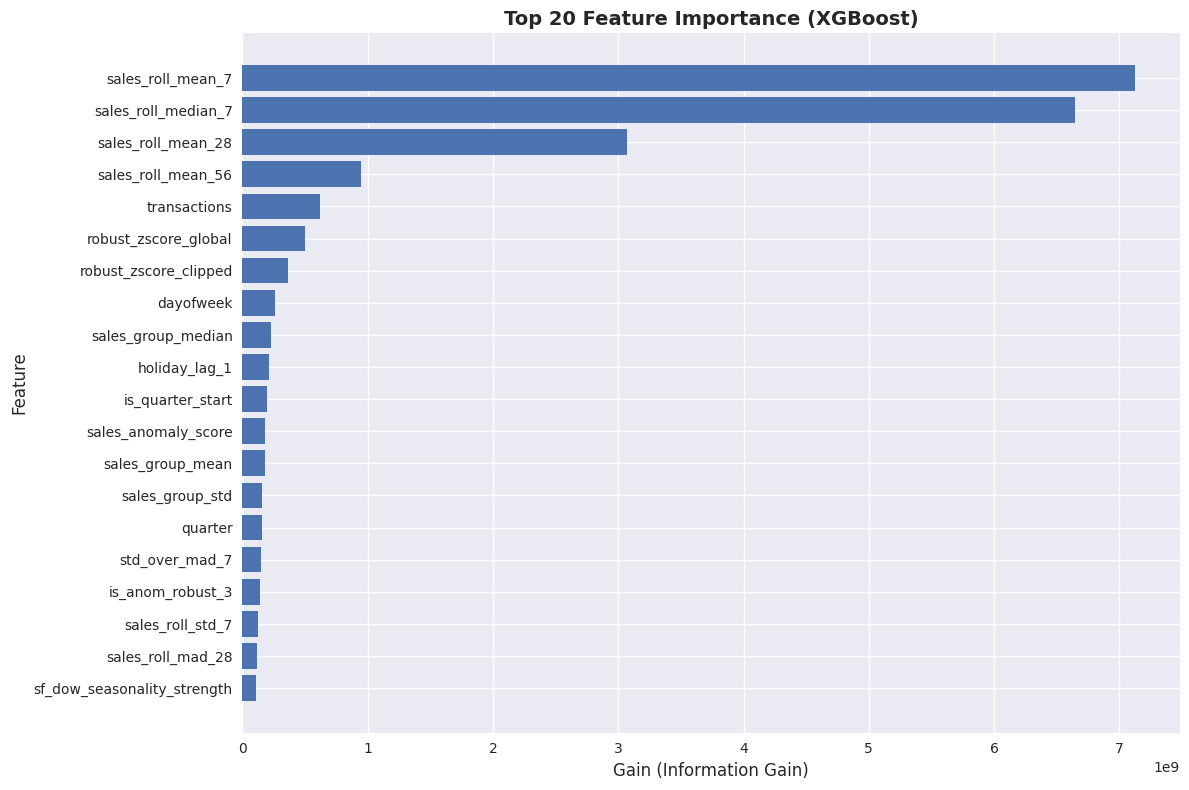


Feature Type Summary:
  Rolling stats            : 18258734588.00 ( 79.1%)
  Time features            : 805194037.00 (  3.5%)
  Categorical enc          : 97686375.50 (  0.4%)
  Derived ratios           : 559310338.00 (  2.4%)
  Advanced (robust)        : 1880147600.00 (  8.1%)
  Structural (CoV)         : 143347536.00 (  0.6%)
  Promotions               : 180212008.50 (  0.8%)
  Holidays                 : 274223751.19 (  1.2%)
  Events (payday/eq)       : 135648507.00 (  0.6%)
  Oil price features       : 8110838.62 (  0.0%)


In [24]:
# Cell 10 – Feature Importance Analysis
if XGB_AVAILABLE and 'model' in globals():
    print("Feature Importance Analysis")
    print("="*60)

    importance = model.get_score(importance_type='gain')

    if not importance:
        print("No importance information available from model.")
    else:
        importance_df = (
            pd.DataFrame({
                'feature': list(importance.keys()),
                'gain': list(importance.values()),
            })
            .sort_values('gain', ascending=False)
            .reset_index(drop=True)
        )

        # Figure out the final feature list we used for training
        FEATURES_FOR_MODEL = (
            FINAL_FEATURE_COLS
            if 'FINAL_FEATURE_COLS' in globals()
            else feature_cols
        )

        # Detect whether XGBoost used f0, f1, ... or real column names
        sample_key = next(iter(importance.keys()))
        uses_f_indices = sample_key.startswith('f') and sample_key[1:].isdigit()

        if uses_f_indices:
            feature_map = {f"f{i}": name for i, name in enumerate(FEATURES_FOR_MODEL)}
            importance_df['feature_name'] = importance_df['feature'].map(feature_map)
        else:
            # Keys are already column names
            importance_df['feature_name'] = importance_df['feature']

        # Fallback if mapping fails
        importance_df['feature_name'] = importance_df['feature_name'].fillna(
            importance_df['feature']
        )

        print("\nTop 20 Most Important Features:")
        print(
            importance_df[['feature_name', 'gain']]
            .head(20)
            .to_string(index=False)
        )

        # ---- Plot top 20 ----
        plt.figure(figsize=(12, 8))
        top_features = importance_df.head(20)
        plt.barh(
            top_features['feature_name'].iloc[::-1],
            top_features['gain'].iloc[::-1]
        )
        plt.xlabel('Gain (Information Gain)', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.title('Top 20 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

        # ---- Summary by feature type ----
        print("\nFeature Type Summary:")

        # Safely get feature blocks if they exist
        rolling_block     = globals().get('rolling_cols', [])
        lag_block         = globals().get('lag_cols', [])
        time_block        = globals().get('time_features', [])
        cat_block         = globals().get('categorical_features', [])
        derived_block     = globals().get('derived_cols', [])
        advanced_block    = globals().get('advanced_cols', [])
        structural_block  = globals().get('structural_cols', [])
        promo_block       = globals().get('promo_cols', [])
        holiday_block     = globals().get('holiday_cols', [])
        event_block       = globals().get('event_cols', [])
        oil_block         = globals().get('oil_cols', [])

        total_gain = importance_df['gain'].sum()

        def summarize_block(label, feat_list):
            if not feat_list:
                return
            block_gain = importance_df[
                importance_df['feature_name'].isin(feat_list)
            ]['gain'].sum()
            if block_gain > 0:
                pct = 100.0 * block_gain / total_gain
                print(f"  {label:25s}: {block_gain:10.2f} ({pct:5.1f}%)")

        summarize_block("Rolling stats",        rolling_block)
        summarize_block("Lag features",         lag_block)
        summarize_block("Time features",        time_block)
        summarize_block("Categorical enc",      cat_block)
        summarize_block("Derived ratios",       derived_block)
        summarize_block("Advanced (robust)",    advanced_block)
        summarize_block("Structural (CoV)",     structural_block)
        summarize_block("Promotions",           promo_block)
        summarize_block("Holidays",             holiday_block)
        summarize_block("Events (payday/eq)",   event_block)
        summarize_block("Oil price features",   oil_block)

else:
    print("Model not available or XGBoost not loaded – train the model first.")


---

## 11. Validation Predictions & Metrics

Evaluate model performance on hold-out validation set.

Generating validation predictions...
Validation rows: 49,896
Validation feature shape: (49896, 87)


 Validation Metrics:
  RMSE (Root Mean Squared Error):    61.9996
  MAE  (Mean Absolute Error):        21.0376
  MAPE (Mean Abs % Error):             24.00%


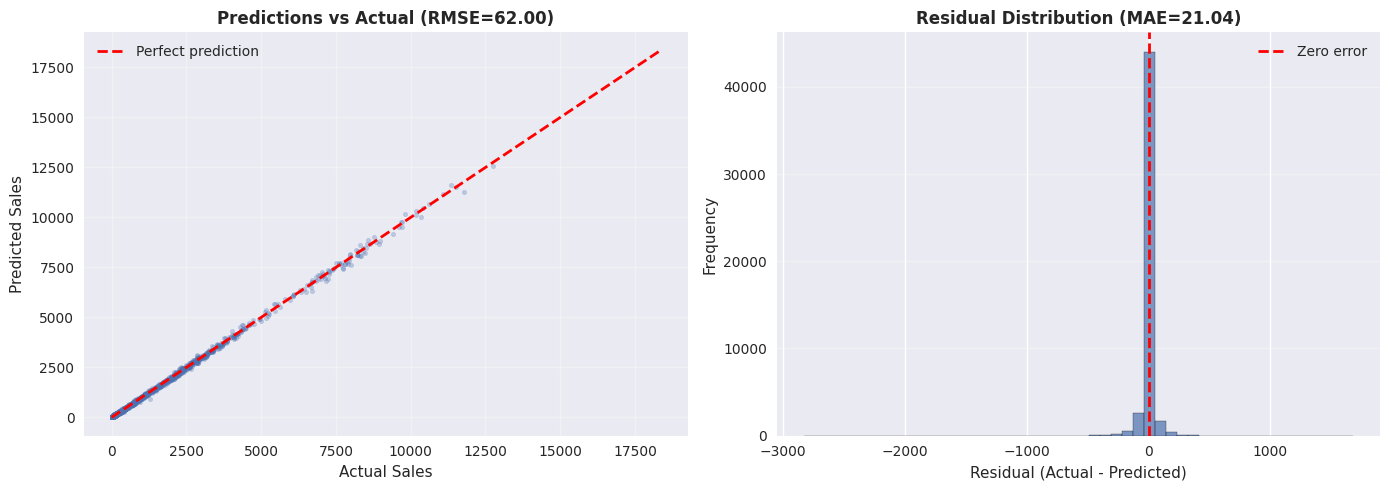

In [25]:
# Cell 11 – Validation Predictions & Metrics
if XGB_AVAILABLE and 'model' in globals():
    print("Generating validation predictions...")
    print("="*60)

    # ---------------------------------------------
    # 1) Rebuild validation slice from `train`
    # ---------------------------------------------
    val_horizon_days = 28
    max_date = train['date'].max()
    val_cutoff = max_date - pd.Timedelta(days=val_horizon_days)

    val_df = train[train['date'] > val_cutoff].copy()

    FEATURES_FOR_MODEL = (
        FINAL_FEATURE_COLS
        if 'FINAL_FEATURE_COLS' in globals()
        else feature_cols
    )

    X_val_eval = val_df[FEATURES_FOR_MODEL].astype('float32')
    y_val_eval = val_df['sales'].astype('float32').values

    print(f"Validation rows: {X_val_eval.shape[0]:,}")
    print(f"Validation feature shape: {X_val_eval.shape}\n")

    # ---------------------------------------------
    # 2) Build DMatrix and predict
    # ---------------------------------------------
    dval_eval = xgb.DMatrix(X_val_eval, missing=np.nan)

    # Respect early stopping: use best_ntree_limit if available
    best_ntree_limit = getattr(model, "best_ntree_limit", None)
    if best_ntree_limit is not None:
        val_preds = model.predict(dval_eval, ntree_limit=best_ntree_limit)
    else:
        val_preds = model.predict(dval_eval)

    # Enforce non-negative predictions
    val_preds = np.maximum(0, val_preds)

    # ---------------------------------------------
    # 3) Metrics
    # ---------------------------------------------
    rmse = np.sqrt(mean_squared_error(y_val_eval, val_preds))
    mae  = mean_absolute_error(y_val_eval, val_preds)
    mape = 100 * np.mean(np.abs((y_val_eval - val_preds) / (y_val_eval + 1)))

    print("\n Validation Metrics:")
    print(f"  RMSE (Root Mean Squared Error): {rmse:>10.4f}")
    print(f"  MAE  (Mean Absolute Error):     {mae:>10.4f}")
    print(f"  MAPE (Mean Abs % Error):        {mape:>10.2f}%")

    # ---------------------------------------------
    # 4) Plots: predictions vs actual & residuals
    # ---------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scatter plot (sampled)
    sample_size = min(5000, len(y_val_eval))
    axes[0].scatter(
        y_val_eval[:sample_size],
        val_preds[:sample_size],
        alpha=0.3,
        s=10,
    )
    max_actual = float(y_val_eval.max())
    axes[0].plot(
        [0, max_actual],
        [0, max_actual],
        'r--',
        lw=2,
        label='Perfect prediction',
    )
    axes[0].set_xlabel('Actual Sales', fontsize=11)
    axes[0].set_ylabel('Predicted Sales', fontsize=11)
    axes[0].set_title(f'Predictions vs Actual (RMSE={rmse:.2f})',
                      fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Residuals histogram
    residuals = y_val_eval - val_preds
    axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(0, color='r', linestyle='--', lw=2, label='Zero error')
    axes[1].set_xlabel('Residual (Actual - Predicted)', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title(f'Residual Distribution (MAE={mae:.2f})',
                      fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

else:
    print("⚠️ XGBoost model not available. Train the model before running validation metrics.")


### 12 model metadata for later reuse

In [26]:
import json, os
from datetime import datetime

print("Saving v1 model metadata...")
print("="*60)

os.makedirs("models", exist_ok=True)

# 1) Final feature list
FINAL_FEATURE_COLS = list(feature_cols)

# 2) Validation horizon
VAL_HORIZON_DAYS = 28

# 3) Date ranges for train / val
train_date_min = train_df['date'].min()
train_date_max = train_df['date'].max()
val_date_min   = val_df['date'].min()
val_date_max   = val_df['date'].max()

# 4) Prepare a metadata
metadata = {
    "model_version": "hpcs_store_sales_v1_raw_target",
    "created_at": datetime.utcnow().isoformat() + "Z",

    # Data / split info
    "val_horizon_days": VAL_HORIZON_DAYS,
    "train_date_min": train_date_min.strftime("%Y-%m-%d"),
    "train_date_max": train_date_max.strftime("%Y-%m-%d"),
    "val_date_min":   val_date_min.strftime("%Y-%m-%d"),
    "val_date_max":   val_date_max.strftime("%Y-%m-%d"),

    # Features and params
    "features": FINAL_FEATURE_COLS,
    "params": {k: (float(v) if isinstance(v, (np.floating,)) else int(v) if isinstance(v, (np.integer,)) else v)
               for k, v in params.items()},

    # v1 metrics
    "metrics_v1": {
        "rmse": float(rmse),
        "mae":  float(mae),
        "mape": float(mape),
    },

    "hpcs_version":  str(getattr(hpcs, "__version__", "unknown")),
    "xgboost_version": str(getattr(xgb, "__version__", "unknown")),
}

meta_path = "models/model_metadata.json"
with open(meta_path, "w") as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Metadata saved to {meta_path}")
print(f"   Features: {len(FINAL_FEATURE_COLS)}")
print(f"   Params keys: {list(metadata['params'].keys())}")
print(f"   v1 RMSE: {metadata['metrics_v1']['rmse']:.4f}")

Saving v1 model metadata...
✅ Metadata saved to models/model_metadata.json
   Features: 87
   Params keys: ['objective', 'eval_metric', 'max_depth', 'eta', 'subsample', 'colsample_bytree', 'min_child_weight', 'lambda', 'alpha', 'tree_method', 'max_bin', 'nthread', 'seed', 'verbosity']
   v1 RMSE: 61.9996


## Summary & Results 

### What We Accomplished

✅ **Data Loading & Prep**
- Loaded and joined **3M+ rows** of Store Sales data (train) with stores, oil, holidays, transactions.
- Engineered **87 final features** per row (time, HPCSeries, domain-specific).

✅ **HPCSeries Feature Blocks**
- **Rolling stats (Block A):**
  - Windows: 7, 28, 56 days
  - Stats: mean, median, std, MAD
- **Derived ratios (Block A):**
  - MAD / median (robust CoV)
  - STD / MAD (outlier index)
  - MAD / mean (volatility index)
- **Advanced robust stats (Block B):**
  - Global robust z-scores (MAD-based)
  - Clipped z-scores, anomaly flags, anomaly density
  - Group aggregates: mean, std, median, MAD, std-based anomaly score
- **Structural features (Block C):**
  - Day-of-week seasonality strength
  - Coefficient of variation of sales
- **Lag features (Block A extension):**
  - sales_lag_7, sales_lag_14, sales_lag_28

Total **HPCSeries-driven features:** **35**  
Total **domain-specific features (promo, holidays, events, oil):** **34**  

✅ **Model Training (XGBoost)**
- Tree method: `hist` (CPU-optimized)
- Objective: `reg:squarederror`
- 87 features, ~2.95M training rows
- **Training time:** ~107 seconds (AMD Ryzen 4C/8T)
- **Early stopping:** best iteration ≈ 399

✅ **Validation Performance (last 28 days)**
- **RMSE:** ≈ **62.00**
- **MAE:** ≈ **21.04**
- **MAPE:** ≈ **24.0%**
- Non-negative predictions enforced.

### Feature Importance Highlights

Top drivers (by gain):

- **Rolling 7-day stats:** `sales_roll_mean_7`, `sales_roll_median_7`
- **Longer windows:** `sales_roll_mean_28`, `sales_roll_mean_56`
- **Store activity:** `transactions`
- **Robust anomalies:** `robust_zscore_global`, `robust_zscore_clipped`, `is_anom_robust_3`
- **Group baselines:** `sales_group_median`, `sales_group_mean`, `sales_group_std`
- **Calendar & holidays:** `dayofweek`, `quarter`, `is_quarter_start`, `holiday_lag_1`
- **Seasonality:** `sf_dow_seasonality_strength`

This confirms that **HPCSeries rolling + robust features** are central to model performance.

### HPCSeries Performance Benefits (Qualitative)

- SIMD-accelerated (AVX2) rolling & robust statistics on 3M+ rows.
- Per-group processing (store, family) for cache-friendly, parallelizable loops.
- MAD-based robust z-scores and volatility measures to handle outliers.
- Clean separation between:
  - Core numeric kernels (HPCSeries)
  - Domain features (promos, holidays, events, oil)
  - Model layer (XGBoost)

---


In [27]:
sample_submission = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

print("Kaggle Submission Format:")
print("="*60)
print(sample_submission.head(10))
print(f"\nShape: {sample_submission.shape}")
print(f"\nColumns: {list(sample_submission.columns)}")
print(f"\nTo submit predictions:")
print("  1. Generate predictions for test set")
print("  2. Create DataFrame with 'id' and 'sales' columns")
print("  3. Save as: submission.to_csv('submission.csv', index=False)")
print("  4. Upload to Kaggle competition page")

Kaggle Submission Format:
        id  sales
0  3000888    0.0
1  3000889    0.0
2  3000890    0.0
3  3000891    0.0
4  3000892    0.0
5  3000893    0.0
6  3000894    0.0
7  3000895    0.0
8  3000896    0.0
9  3000897    0.0

Shape: (28512, 2)

Columns: ['id', 'sales']

To submit predictions:
  1. Generate predictions for test set
  2. Create DataFrame with 'id' and 'sales' columns
  3. Save as: submission.to_csv('submission.csv', index=False)
  4. Upload to Kaggle competition page
